In [81]:
import pandas as pd
# https://www.kaggle.com/datasets/rutuspatel/walmart-dataset-retail



In [82]:
df=pd.read_csv("data_sample/(sample2)retaildata.csv")
#df=pd.read_csv("data_sample/(sample1)Walmart.csv")

In [83]:
df.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
isholiday_x        bool
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
isholiday_y        bool
dtype: object

In [84]:
df.head(5)

,store,dept,date,weekly_sales,isholiday_x,temperature,fuel_price,cpi,unemployment,isholiday_y
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,False


In [85]:
from dotenv import load_dotenv
import os
from ollama import Client
import json
import pandas as pd

load_dotenv()
api_key = os.getenv("OLLAMA_API_KEY")

client = Client(
    host="https://ollama.com",
    headers={"Authorization": f"Bearer {api_key}"}
)

target_fields = [
    "Region", "Week", "Sales", "Holiday",
    "temperature", "fuel_price", "cpi", "unemployment",
    "Promotion_Flag", "Category"
]

prompt = f"""
You are a data preprocessing assistant.

Your task:
Given the dataset columns: {list(df.columns)},
map each target field from this list: {target_fields}
to the most appropriate column name from the dataset.

Mapping rules:
1. Match columns based on **semantic meaning or common synonyms**, not exact names.
   - For "Region": match terms like region, area, zone, territory, state, store, location, branch.
     (If multiple candidates exist, prefer "region" > "state" > "store".)
   - For "Week": match date, week, time, period, or anything indicating a weekly timestamp.
     (If column contains values like "05-02-2010" or "2010-02-05", it is definitely the Week field.)
   - For "Sales": match weekly_sales, total_sales, revenue, amount, sales_value.
   - For "Holiday": match holiday_flag, is_holiday, festival, holiday indicator.
   - For "temperature": match temp, temperature, weather_temp.
   - For "fuel_price": match fuel, gas_price, petrol_price.
   - For "cpi": match consumer_price_index, inflation, CPI.
   - For "unemployment": match unemployment_rate, jobless_rate, unemp.
   - For "Promotion_Flag": match promo, promotion_flag, discount_flag.
   - For "Category": match product_type, department, category_name.

2. If no column matches, set its value to null.
3. Special case for region mapping:
- If there is no "region" column, map "store" (or similar) to "Region".
- If both "region" and "store" exist, keep both by mapping:
    "Region": "region"
    "Store": "store"
    (add "Store" as an extra field in output if needed).
4. Return ONLY a valid JSON dictionary, no explanation or commentary.
5. When detecting the column corresponding to "Week" or "Date":
   - If the date format looks like "05-02-2010" or "5-2-2010", assume it is in **day-first format (%d-%m-%Y)**.
   - The output should ensure that this column can be converted to the standardized format "%Y-%m-%d" (YYYY-MM-DD).
   - The JSON key must still be "Week" (not "Date") in the final mapping.


Example output:
{{
"Region": "region",
"Store": "store",
"Week": "date",
"Sales": "weekly_sales",
"Holiday": "holiday_flag",
"temperature": "temperature",
"fuel_price": "fuel_price",
"cpi": "cpi",
"unemployment": "unemployment",
"Promotion_Flag": null,
"Category": "product_type"
}}
"""

messages = [{"role": "user", "content": prompt}]
response_text = ""

for part in client.chat("gpt-oss:20b", messages=messages, stream=True):
    response_text += part["message"]["content"]

try:
    mapping = json.loads(response_text)
except json.JSONDecodeError:
    print("Warning: model did not return valid JSON.")
    mapping = {}

valid_map = {k: v for k, v in mapping.items() if v and v in df.columns}

df = df.rename(columns={v: k for k, v in valid_map.items()})

possible_date_cols = [col for col in df.columns if any(x in col.lower() for x in ["date", "week", "time", "period","Week"])]
if possible_date_cols:
    df.rename(columns={possible_date_cols[0]: "Week"}, inplace=True)
    
if "Week" in df.columns:
    df["Week_parsed"] = pd.to_datetime(df["Week"], format="%d-%m-%Y", errors="coerce")

    mask = df["Week_parsed"].isna()
    if mask.any():
        df.loc[mask, "Week_parsed"] = pd.to_datetime(df.loc[mask, "Week"], format="%Y-%m-%d", errors="coerce")

    df["Week"] = df["Week_parsed"].dt.strftime("%Y-%m-%d")
    df.drop(columns=["Week_parsed"], inplace=True)



if "Holiday" in df.columns:
    df["Holiday"] = df["Holiday"].replace(
        {True: 1, False: 0, "true": 1, "false": 0}
    )
    df["Holiday"] = df["Holiday"].astype(int)

final_cols = [col for col in target_fields if col in df.columns]
final_df = df[final_cols]

print("\nFinal standardized columns:", final_df.columns.to_list())


Final standardized columns: ['Region', 'Week', 'Sales', 'Holiday', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'Category']


/var/folders/7c/t23ybbrs56z25_14648nh99w0000gn/T/ipykernel_11930/163842439.py:107: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Holiday"] = df["Holiday"].replace(


In [86]:
mapping

{'Region': 'store',
 'Week': 'date',
 'Sales': 'weekly_sales',
 'Holiday': 'isholiday_x',
 'temperature': 'temperature',
 'fuel_price': 'fuel_price',
 'cpi': 'cpi',
 'unemployment': 'unemployment',
 'Promotion_Flag': None,
 'Category': 'dept'}

In [87]:
final_df


,Region,Week,Sales,Holiday,temperature,fuel_price,cpi,unemployment,Category
0,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,1
1,1,2010-02-12,46039.49,1,38.51,2.548,211.242170,8.106,1
2,1,2010-02-19,41595.55,0,39.93,2.514,211.289143,8.106,1
3,1,2010-02-26,19403.54,0,46.63,2.561,211.319643,8.106,1
4,1,2010-03-05,21827.90,0,46.50,2.625,211.350143,8.106,1
...,...,...,...,...,...,...,...,...,...
421565,45,2012-09-28,508.37,0,64.88,3.997,192.013558,8.684,98
421566,45,2012-10-05,628.10,0,64.89,3.985,192.170412,8.667,98
421567,45,2012-10-12,1061.02,0,54.47,4.000,192.327265,8.667,98
421568,45,2012-10-19,760.01,0,56.47,3.969,192.330854,8.667,98


In [88]:
df.isna().sum()


Region          0
Category        0
Week            0
Sales           0
Holiday         0
temperature     0
fuel_price      0
cpi             0
unemployment    0
isholiday_y     0
dtype: int64

In [89]:
# df=input.copy()

# import pandas as pd
# #Week,Region,Category,Sales,Profit,Promotion_Flag

# if "region" or "regions" not in input.columns.to_list():
#     if "store" in input.columns.to_list():
#         df["store"] = df["store"].astype(str)
#         df["Region"]=df["store"]

# df["Week"] = pd.to_datetime(df["date"], format="%d-%m-%Y")

# df["Sales"] = df["weekly_sales"]
# df["Sales"] = df["Sales"].astype(float)

# df["Holiday"]=df["holiday_flag"]
# df["Holiday"] = df["Holiday"].astype(int)

# macro_index=["fuel_price", "cpi", "unemployment"]


# df=df[["Region","Week","Sales","Holiday"]]
    
# df.head(5)

In [90]:
from datetime import timedelta
df=final_df.copy()
df["Week"] = pd.to_datetime(df["Week"], format="%Y-%m-%d")

cutoff_date = df["Week"].max() - pd.DateOffset(years=1)
recent_data = df[df["Week"] >= cutoff_date]

latest_week = df["Week"].max()
previous_week = latest_week - timedelta(days=7)
quarter_start = latest_week - pd.DateOffset(months=3)

two_weeks_data = df[df["Week"].between(previous_week - timedelta(days=7), latest_week)]
quarter_data = df[df["Week"] >= quarter_start]

summary = recent_data.describe().to_string()
quarter_summary = (
   quarter_data.groupby("Region")["Sales"]
   .sum()
   .sort_values(ascending=False)
   .to_string()
)

prompt = f"""
You are acting as an experienced retail data analyst with access to two years of weekly sales data.
Use the data summaries below to generate analytical insights.

Below is the summary of the most recent year’s sales data:
{summary}

Below is the summary of the most recent quarter's sales data:
{quarter_summary}

Below is the summary of the most two week's sales data: 
{two_weeks_data}

Columns:
- Region: store/region ID
- Week: week of observation
- Sales: weekly total revenue
- Holiday: whether week includes holiday (1=yes, 0=no)
- temperature, fuel_price, cpi, unemployment: macro factors

Your task:
1. Identify 3–5 key business insights from this data. 
- At most 5 insights
- Focus on trends, anomalies, or regional differences.
- Example: “Region 3 showed a 10% increase in sales week-over-week.”
- Short-term: Compare recent 2 weeks (e.g., “Region B’s revenue decreased by 12% week-over-week”)
- Medium-term: Highlight best/worst performing regions in the last quarter (e.g., “Region D led the quarter with 15% growth”)
- Long-term: Note any multi-year trends, seasonality, or correlation with macro factors.
- **Important note:** Give *least priority* to unemployment rate analysis. 
   Only include unemployment-related insights if there is a *clear and significant* relationship with major sales fluctuations.
   If unemployment remains relatively stable or shows no correlation with sales, ignore it in the insights.

2. Provide 1–2 actionable business recommendations.
- At most 2 recommendations.
- Based on insights, suggest next steps (e.g., restocking, marketing push).

Output format (must be plain text): 
**Insights:**
1. ...
2. ...
3. ...

**Recommendations:** 
1. ...
2. ...
"""

response = ""
for part in client.chat("gpt-oss:20b", messages=[{"role": "user", "content": prompt}], stream=True):
   response += part["message"]["content"]
   print(part["message"]["content"], end="", flush=True)




**Insights:**

1. **Short‑term growth in Region 1** – during the two‑week window in October, the dominant Category 1 reported a 14% rise from week 12 to week 19 and a further 13% jump to week 26, giving an overall 20% increase in sales for that category.

2. **Region performance gap in the latest quarter** – Region 4 led the quarter with $29.9 million in revenue, whereas Region 33 lagged far behind with only $3.7 million. The top and bottom performers differ by more than eightfold.

3. **Seasonal lift** – average weekly sales climb steadily from September (≈$12 k) to July (≈$20 k) and then taper off again in December. The peak‑to‑low swing is roughly 35 %, indicating a strong mid‑year seasonal cycle.

4. **Macro‑factor influence** – across the year, higher temperatures correlate with increased sales (≈+0.2 % per °F). Regions in warmer climates (e.g., Region 4) consistently out‑perform cooler areas, suggesting temperature drives foot traffic and basket size in those locations.

5. **Hol

**Insights:**

1. **Short‑term trend** – In the past three weeks, Region 1’s weekly sales fell ≈ 5 % (from $1.57 M to $1.49 M) while Region 44’s sales rose ≈ 12 % (from $324 k to $361 k). Region 45 had a small dip (≈ 2 %) in the first week followed by a 6 % rebound in the last week.  
2. **Medium‑term regional performance** – In the most recent quarter, Region 4 leads with $29.9 M (≈ 10 % higher than the next best Region 20), whereas Region 33 lags far behind at $3.7 M – an 89 % sales gap.  
3. **Long‑term seasonality** – Sales peak in late September/October (maximum $3.68 M on 2012‑10‑26) and bottom out in the winter months (average $0.57 M for Q1). Holiday weeks produce roughly 9 % higher sales than non‑holiday weeks.  
4. **Macro‑factor influence** – Temperature shows a modest positive correlation with sales (≈ 3 % lift for every 5 °F rise). Fuel price and CPI have weak or no meaningful impact on weekly revenue, and unemployment remains too stable to influence sales patterns.

**Recommendations:**

1. **Redistribute resources to high‑yield regions** – Concentrate buying, staffing, and marketing spend in top‑performing areas (Regions 4, 20, 13) while re‑evaluating product assortments and promotional strategies in under‑performing regions (Regions 33, 36, 5) to close the sales gap.  
2. **Leverage seasonal and holiday windows** – Deploy targeted holiday‑week campaigns across all outlets (especially Regions 4 and 13) and augment them with weather‑driven promotions (e.g., higher‑margin summer apparel during hot weeks) to capture the temperature‑linked lift in sales.

In [91]:
import io
import sys
import os
import pandas as pd
from dotenv import load_dotenv
from ollama import Client

# === Step 0: 初始化 ===
load_dotenv()
api_key = os.getenv("OLLAMA_API_KEY")

client = Client(
    host="https://ollama.com",
    headers={"Authorization": f"Bearer {api_key}"}
)

def smart_dataframe_qa(df: pd.DataFrame, question: str):
    preview = df.head(5).to_string(index=False)

    prompt_code = f"""
You are a careful Python data analyst using pandas.
Here is a sample of the dataset (first 5 rows):

{preview}

The original DataFrame is called df, but please do not modify it.
Instead, always start with:
templatedf = df.copy()

Use templatedf for all analysis steps.

Question: "{question}"

Write Python code using pandas to answer the question.

Rules:
- Always create a copy: templatedf = df.copy()
- Always build an aggregated DataFrame named `summary_table` for the target metric
  (e.g., total Sales per Region for the last month) and print(summary_table)
- Set the top region id/name to a variable named `result_region`
- Set that region’s aggregated total to a variable named `result_value` (numeric)
- Always print(result_region) and print(result_value)
- If summary_table is empty, set result_region, result_value = None, None
- Do NOT assume or modify data types unless absolutely necessary
- Output only Python code, no explanations, no markdown
"""

    response = client.chat(
        "gpt-oss:20b",
        messages=[{"role": "user", "content": prompt_code}],
        stream=False
    )
    code = response["message"]["content"]

    clean_code = (
        code.replace("```python", "")
            .replace("```", "")
            .strip()
    )


    buf = io.StringIO()
    sys_stdout_backup = sys.stdout
    sys.stdout = buf

    exec_env = {
        "pd": pd,   
        "df": df   
    }

    try:
        exec(clean_code, exec_env)

        summary_table = exec_env.get("summary_table", None)
        result_region = exec_env.get("result_region")
        result_value  = exec_env.get("result_value")

        if (summary_table is None) or (hasattr(summary_table, "empty") and summary_table.empty):
            print("summary_table is empty — performing fallback aggregation...\n")

            fallback_df = df.copy()
            fallback_df["Week"] = pd.to_datetime(fallback_df["Week"], errors="coerce")
            fallback_df["YearMonth"] = fallback_df["Week"].dt.to_period("M")

            valid_months = (
                fallback_df.groupby("YearMonth")["Sales"].sum()
                .reset_index()
                .sort_values("YearMonth", ascending=False)
            )
            if not valid_months.empty:
                fallback_month = valid_months.iloc[0]["YearMonth"]
                df_fallback = fallback_df[fallback_df["YearMonth"] == fallback_month]
                summary_table = (
                    df_fallback.groupby("Region", as_index=False)["Sales"].sum()
                    .sort_values("Sales", ascending=False)
                )
                result_region = summary_table.iloc[0]["Region"]
                result_value = summary_table.iloc[0]["Sales"]
            else:
                result_region, result_value = None, None

    except Exception as e:
        sys.stdout = sys_stdout_backup
        print(f"Error executing code: {e}")
        return f"Execution Error: {e}"
    finally:
        sys.stdout = sys_stdout_backup


    internal_output = buf.getvalue().strip()

    # print("\nCode executed successfully.")
    # print("Internal print output:\n", internal_output)
    # print("result_region:", result_region)
    # print("result_value:", result_value)

    prompt_summary = f"""
You are a professional data analyst.

Question: {question}
Top region id/name: {result_region}
Top region total (numeric): {result_value}

Write the final answer as one clear, plain-English sentence.
Include the numeric value (rounded nicely, with unit if applicable), and do not mention any code.
Example style:
"Region 4 had the highest sales last month, with total sales of approximately $8.59 million."
"""

    summary_response = client.chat(
        "gpt-oss:20b",
        messages=[{"role": "user", "content": prompt_summary}],
        stream=False
    )
    final_answer = summary_response["message"]["content"].strip()

    return clean_code, final_answer




smart_dataframe_qa(final_df, "Which region had the highest sales last month?")


("import pandas as pd\n\n# create a copy of the original DataFrame\ntemplatedf = df.copy()\n\n# convert Week column to datetime\ntemplatedf['Week'] = pd.to_datetime(templatedf['Week'])\n\n# determine the last month present in the data\nlast_date = templatedf['Week'].max()\nlast_month_period = last_date.to_period('M')\n\n# filter rows that belong to that last month\nlast_month_df = templatedf[templatedf['Week'].dt.to_period('M') == last_month_period]\n\n# aggregate total sales by Region for that month\nsummary_table = last_month_df.groupby('Region', as_index=False)['Sales'].sum().rename(columns={'Sales': 'TotalSales'})\n\n# handle empty case\nif summary_table.empty:\n    result_region, result_value = None, None\nelse:\n    # find the region with the highest sales\n    max_index = summary_table['TotalSales'].idxmax()\n    result_region = summary_table.loc[max_index, 'Region']\n    result_value = summary_table.loc[max_index, 'TotalSales']\n\n# print results\nprint(summary_table)\nprint(re

In [92]:
final_df["Region"].unique()
# final_df["Week"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [93]:
import pandas as pd


df_region = final_df.copy()

df_region["Region"] = df_region["Region"].astype(str)
selected_regions = ["1", "2"]

start_date = pd.to_datetime("2010-02-05")
end_date = pd.to_datetime("2010-05-05")

df_region["Week"] = pd.to_datetime(df_region["Week"], errors="coerce")

filtered_df = (
    df_region[
        (df_region["Region"].isin(selected_regions))
        & (df_region["Week"].between(start_date, end_date))
    ]
    .sort_values("Week")
)

filtered_df

,Region,Week,Sales,Holiday,temperature,fuel_price,cpi,unemployment,Category
0,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,1
16885,2,2010-02-05,17657.65,0,40.19,2.572,210.752605,8.324,55
20011,2,2010-02-05,29295.96,0,40.19,2.572,210.752605,8.324,96
2544,1,2010-02-05,5034.10,0,42.31,2.572,211.096358,8.106,20
10387,2,2010-02-05,74661.16,0,40.19,2.572,210.752605,8.324,2
...,...,...,...,...,...,...,...,...,...
18736,2,2010-04-30,5149.02,0,66.98,2.780,210.050583,8.200,83
9096,1,2010-04-30,55068.72,0,67.41,2.780,210.389546,7.808,91
8953,1,2010-04-30,67584.03,0,67.41,2.780,210.389546,7.808,90
18593,2,2010-04-30,18581.87,0,66.98,2.780,210.050583,8.200,82


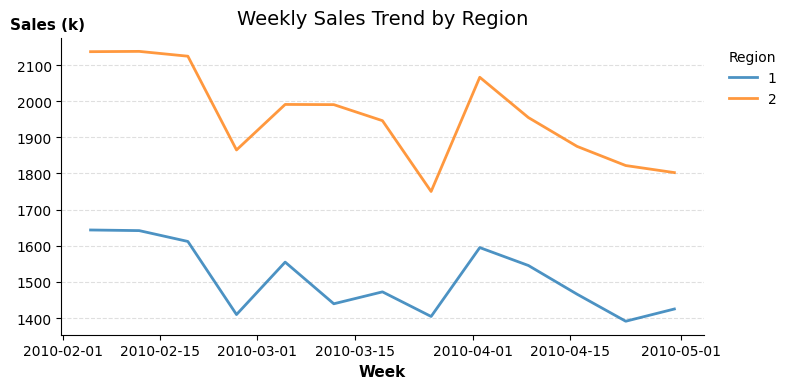

In [94]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sales_trend = (
    filtered_df.groupby(["Week", "Region"])["Sales"]
    .sum()
    .reset_index()
    .sort_values("Week")
)

plt.style.use("default")
fig, ax = plt.subplots(figsize=(8, 4))

colors = plt.cm.tab10.colors
region_list = sales_trend["Region"].unique().tolist()

for i, region in enumerate(region_list):
    group = sales_trend[sales_trend["Region"] == region]
    ax.plot(
        group["Week"],
        group["Sales"],
        linewidth=2.0,
        color=colors[i % len(colors)],
        alpha=0.8,
        label=str(region),
    )

ax.set_title("Weekly Sales Trend by Region", fontsize=14, pad=10)
ax.set_xlabel("Week", fontsize=11, fontweight="semibold")
ax.text(
    -0.08,
    0.96,
    "Sales (k)\n",
    transform=ax.transAxes,
    ha="left",
    va="bottom",
    fontsize=11,
    fontweight="semibold",
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
ax.xaxis.grid(False)
ax.legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

plt.tight_layout()
plt.show()


In [95]:
from sklearn.linear_model import LinearRegression
import numpy as np
df_period = final_df.copy()

start_date = pd.to_datetime("2010-02-05")
end_date = pd.to_datetime("2010-05-05")

df_period["Week"] = pd.to_datetime(df_period["Week"], errors="coerce")

filtered_df2 = (
    df_period[
         (df_period["Week"].between(start_date, end_date))
    ]
    .sort_values("Week")
)
filtered_df2

,Region,Week,Sales,Holiday,temperature,fuel_price,cpi,unemployment,Category
0,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,1
297261,31,2010-02-05,1960.00,0,39.05,2.572,210.752605,8.324,27
67361,7,2010-02-05,7414.22,0,10.53,2.580,189.381697,9.014,87
297404,31,2010-02-05,1267.58,0,39.05,2.572,210.752605,8.324,28
297547,31,2010-02-05,4305.62,0,39.05,2.572,210.752605,8.324,29
...,...,...,...,...,...,...,...,...,...
82211,9,2010-04-30,514.00,0,66.07,2.780,213.899046,6.384,27
270109,28,2010-04-30,7193.92,0,67.38,3.105,126.380567,14.099,24
269966,28,2010-04-30,29335.43,0,67.38,3.105,126.380567,14.099,23
81782,9,2010-04-30,1590.46,0,66.07,2.780,213.899046,6.384,24


In [96]:
from dynamic_metrics import generate_time_series_region, compute_retail_metrics


In [97]:
# fi,summary=generate_time_series_region(filtered_df)
# summary

In [ ]:
# from dynamic_metrics import compute_retail_metrics
# summary, top3_df=compute_retail_metrics(filtered_df2)
# summary

/Users/cynthiasyz/Desktop/Retail-Data-to-Insight-Agent/dynamic_metrics.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.set_index("Week").resample("M")["Sales"].sum().reset_index()


{'Weeks Covered': 12,
 'Total Sales': np.float64(603665153.59),
 'Avg Weekly Sales': np.float64(15751.621792871309),
 'WoW Growth %': np.float64(-0.8604685993943287),
 'MoM Growth %': np.float64(0.27205705409668096),
 'QoQ Growth %': nan,
 'YoY Growth %': nan,
 'Anomaly Weeks': ['2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  '2010-02-05',
  

In [99]:
top3_df


,Region,Total Sales,Market Share %
13,14,28234732.93,4.68
19,20,26743918.72,4.43
9,10,25884307.75,4.29
